# Label Analysis

In [264]:
import pandas as pd
bm = pd.read_csv("Biermann2020/reconstructed_data.csv", index_col=0)


In [266]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import os
from shapely.geometry import mapping
import numpy as np
from tqdm import tqdm

In [267]:
root = "/ssd/floatingObjects/data"


# Extract pixels under the labels

In [346]:
def aggregate_pixels(shp, tif):
    shapefile = gpd.read_file(shp)

    pixels = []

    # extract the geometry in GeoJSON format
    with rasterio.open(tif) as src:
        geoms = shapefile.to_crs(src.crs).geometry.values # list of shapely geometries
        for geometry in geoms:
            geoms = [mapping(geometry)]
            out_image, out_transform = mask(src, geoms, crop=True)

            pixels.append(out_image[:,out_image.sum(0)>0])

    return np.hstack(pixels)

if False:

    regions = [file.replace(".shp","") for file in os.listdir(root) if file.endswith(".shp")]
    regions

    l1cbands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11","B12"]
    l2abands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11","B12"]

    dfs = []
    for region in tqdm(regions):
        l2a = os.path.exists(os.path.join(root, region+"_l2a.tif"))
        if l2a: 
            tif = os.path.join(root, region+"_l2a.tif")
        else:
            tif = os.path.join(root, region+".tif")
        shp = os.path.join(root, region+".shp")

        df = pd.DataFrame(aggregate_pixels(shp, tif).T, columns=l2abands if l2a else l1cbands)
        df["region"] = region
        dfs.append(df)
    dfs = pd.concat(dfs)
    dfs.to_csv(os.path.join(root,"labelled_pixels.csv"))
else:
    dfs = pd.read_csv(os.path.join(root,"labelled_pixels.csv"), index_col=0)
    
dfs = dfs.loc[dfs.region != "toledo_20191221"]

In [347]:
NIR = dfs["B8"]  * 1e-4
RED2 = dfs["B6"] * 1e-4
RED = dfs["B4"] * 1e-4
SWIR1 = dfs["B11"] * 1e-4

lambda_NIR = 832.9
lambda_RED = 664.8
lambda_SWIR1 = 1612.05
NIR_prime = RED2 + (SWIR1 - RED2) * 10 * (lambda_NIR - lambda_RED) / (lambda_SWIR1 - lambda_RED)
dfs["fdi"] = NIR - NIR_prime
dfs["ndvi"] = (NIR - RED) / (NIR + RED)

Text(0.5, 0, '')

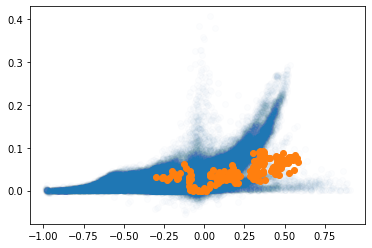

In [348]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(dfs["ndvi"], dfs["fdi"], alpha=0.01)
ax.scatter(bm["ndvi"], bm["fdi"])
ax.set_xlabel("")

<ipython-input-349-97946c575053>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("/tmp/distributions.svg", dpi=None, facecolor='w', edgecolor='w',
<ipython-input-349-97946c575053>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("/tmp/distributions.svg", dpi=None, facecolor='w', edgecolor='w',


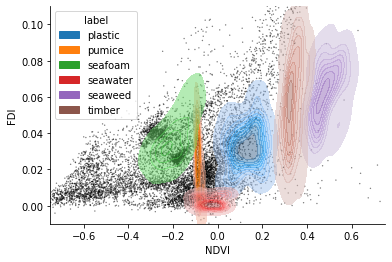

In [349]:
fig, ax = plt.subplots(figsize=(6,4))
df_ = dfs.sample(10000)
ax.scatter(df_["ndvi"], df_["fdi"], s=2, alpha=0.5, edgecolor="none", facecolor="black")
sns.kdeplot(data=bm, x="ndvi", y="fdi", hue="label", ax=ax, alpha=0.5, thresh=0.01, fill=True, legend=True)
sns.despine()
ax.set_xlim(-0.75,0.75)
ax.set_ylim(-.01,0.11)
ax.set_xlabel("NDVI")
ax.set_ylabel("FDI")

fig.savefig("/tmp/distributions.svg", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches="tight", pad_inches=0.1,
        frameon=None, metadata=None)

In [350]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity

labels = ['plastic', 'pumice', 'seafoam', 'seawater', 'seaweed', 'timber']
x = bm[["ndvi","fdi"]].values
y = np.array([labels.index(labelname) for labelname in bm["label"]])
biermann_classifier = GaussianNB()
biermann_classifier.fit(x,y)


GaussianNB()

In [351]:
x_data = dfs[["ndvi", "fdi"]]
y_data = biermann_classifier.predict(x_data)

[Text(0.5, 0, 'plastic'),
 Text(1.5, 0, 'pumice'),
 Text(2.5, 0, 'seafoam'),
 Text(3.5, 0, 'seawater'),
 Text(4.5, 0, 'seaweed'),
 Text(5.5, 0, 'timber')]

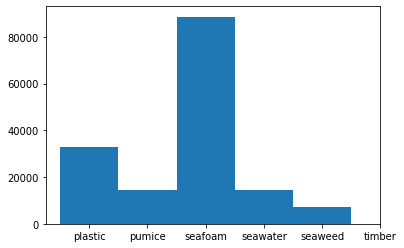

In [352]:
fig, ax = plt.subplots()
ax.hist(y_data, bins=len(labels)-1)
ax.set_xticks(np.arange(len(labels)) + 0.5)
ax.set_xticklabels(labels)

In [353]:
dfs["predicted_label"] = np.array(labels)[y_data]

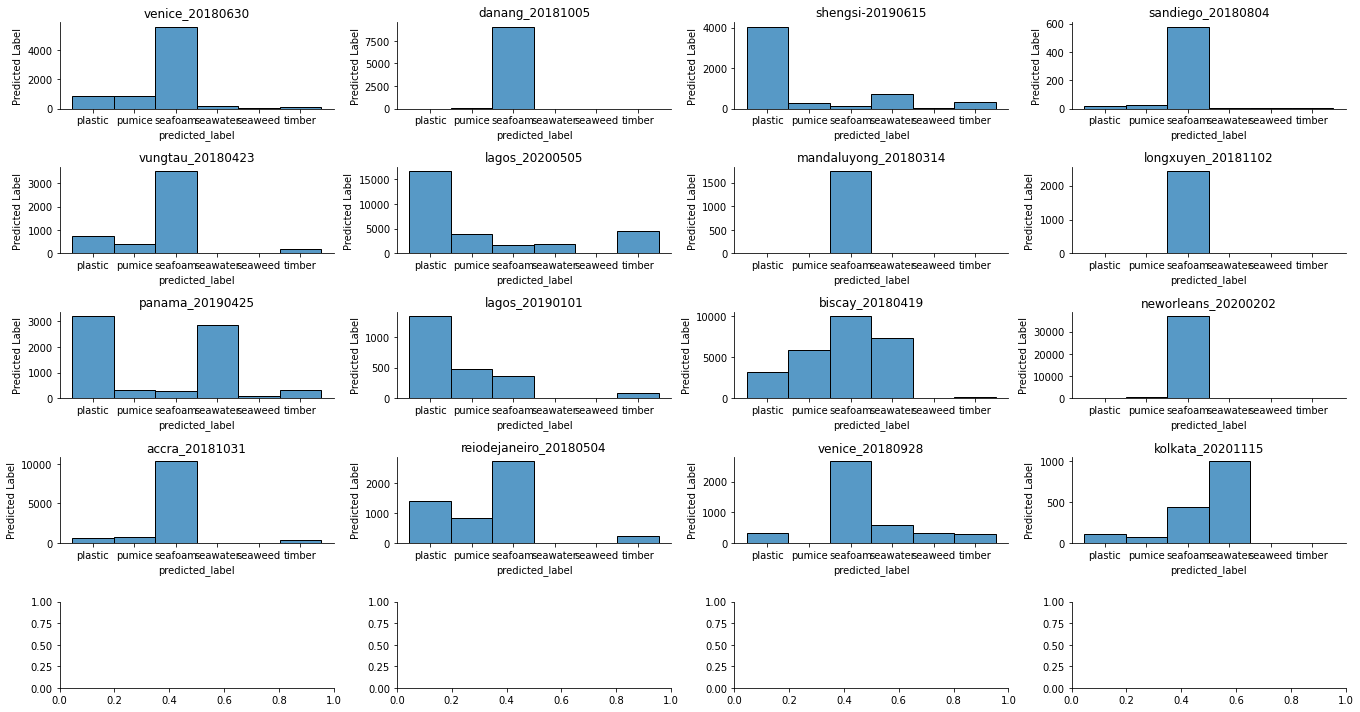

In [354]:
regions = dfs.region.unique()
region = regions[0]

import seaborn as sns

fig, axs = plt.subplots(5,4, figsize=(19,10))
for ax, region in zip(np.array(axs).reshape(-1), regions):
    df = dfs.loc[dfs.region==region]
    # add sone None lines to ensure plotting adds all categories
    df = pd.concat([df, pd.DataFrame(labels, columns=["predicted_label"])])
    # make sure that the sequence of categories is the same for all plots
    df = df.sort_values(by="predicted_label")
    sns.histplot(df, x="predicted_label", ax=ax, common_bins=True, bins=7)
    ax.set_title(region)
    ax.set_ylabel("Pixel Count")
    ax.set_ylabel("Predicted Label")
    
    sns.despine()
plt.tight_layout()

In [360]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity

labels = ['plastic', 'pumice', 'seafoam', 'seawater', 'seaweed', 'timber']
x = bm[["ndvi","fdi"]].values
y = np.array([labels.index(labelname) for labelname in bm["label"]])

kdes = {l:KernelDensity(bandwidth=0.01) for l in labels}
for label, kde in kdes.items():
    X = bm.loc[bm.label == label][["ndvi","fdi"]].values
    kde.fit(X)

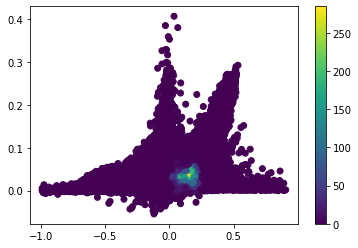

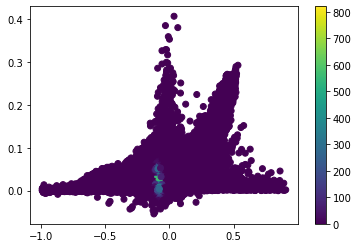

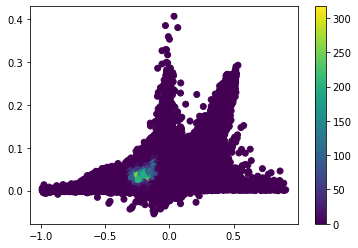

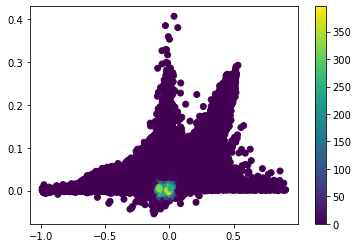

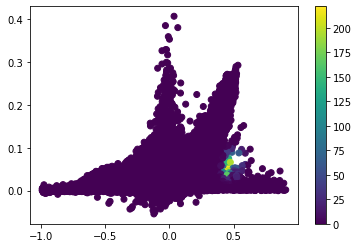

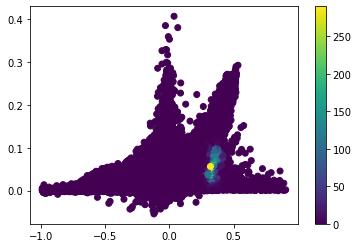

In [361]:
scores = []
for label, kde in kdes.items():
    X = dfs[["ndvi","fdi"]].values
    probs = np.exp(kde.score_samples(X))
    scores.append(probs)
scores = np.stack(scores).T

kdelabels = np.array(['plastic', 'pumice', 'seafoam', 'seawater', 'seaweed', 'timber', "other"])
other = scores.max(1) < 5
predictions = scores.argmax(1)
predictions[other] = 6

for i in range(6):
    plt.figure()
    plt.scatter(x=dfs["ndvi"], y=dfs["fdi"],c=scores[:,i])
    plt.colorbar()
    
    

In [362]:
dfs["predicted_label_kde"] = kdelabels[predictions]

<ipython-input-363-5b072a337766>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right")
<ipython-input-363-5b072a337766>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right")
<ipython-input-363-5b072a337766>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right")
<ipython-input-363-5b072a337766>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right")
<ipython-input-363-5b072a337766>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right")
<ipython-input-363-5b072a337766>:45: UserWarning: FixedFormatter should only be used together with FixedL

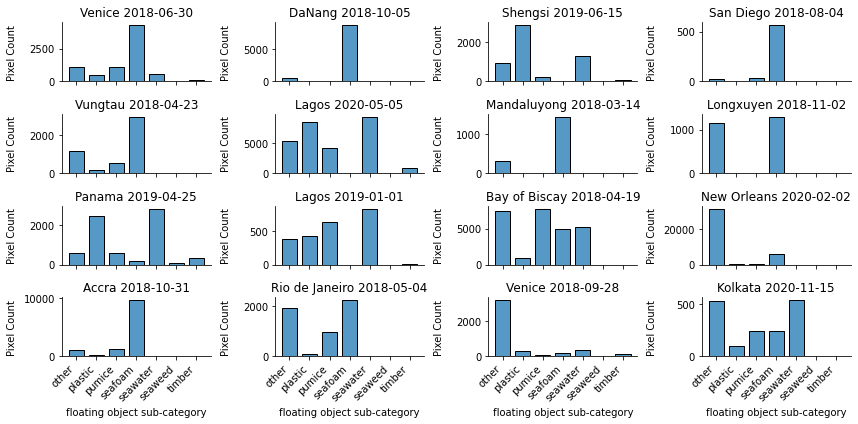

In [363]:
regions = dfs.region.unique()
region = regions[0]

import seaborn as sns
labelx = -0.3  # axes coords

fig, axs = plt.subplots(4,4, figsize=(12,6), sharex=True)
axs = np.array(axs).reshape(-1)
"""
ax=axs[0]
df = dfs
# add sone None lines to ensure plotting adds all categories
df = pd.concat([df, pd.DataFrame(kdelabels, columns=["predicted_label_kde"])])
# make sure that the sequence of categories is the same for all plots
df = df.sort_values(by="predicted_label_kde")
g = sns.histplot(df, x="predicted_label_kde", ax=ax, bins=8, shrink=0.75)
#locs, labels = plt.xticks()
#plt.setp(labels, rotation=45)
ax.set_title("all regions")
ax.set_ylabel("Pixel Count")
ax.set_ylabel("#pixels")
ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right") 
sns.despine()
ax.yaxis.set_label_coords(labelx, 0.5)
"""
titles = ['Venice 2018-06-30', 'DaNang 2018-10-05', 'Shengsi 2019-06-15',
       'San Diego 2018-08-04', 'Vungtau 2018-04-23', 'Lagos 2020-05-05',
       'Mandaluyong 2018-03-14', 'Longxuyen 2018-11-02', 'Panama 2019-04-25',
       'Lagos 2019-01-01', 'Bay of Biscay 2018-04-19', 'New Orleans 2020-02-02',
       'Accra 2018-10-31', 'Rio de Janeiro 2018-05-04', 'Venice 2018-09-28',
       'Kolkata 2020-11-15']

for ax, region, title in zip(axs, regions, titles):
    df = dfs.loc[dfs.region==region]
    # add sone None lines to ensure plotting adds all categories
    df = pd.concat([df, pd.DataFrame(kdelabels, columns=["predicted_label_kde"])])
    # make sure that the sequence of categories is the same for all plots
    df = df.sort_values(by="predicted_label_kde")
    g = sns.histplot(df, x="predicted_label_kde", ax=ax, bins=8, shrink=0.75)
    #locs, labels = plt.xticks()
    #plt.setp(labels, rotation=45)
    ax.set_title(title)
    ax.set_ylabel("Pixel Count")
    ax.set_xlabel("floating object sub-category")
    ax.set_xticklabels(sorted(kdelabels), rotation = 45, ha="right") 
    sns.despine()
    ax.yaxis.set_label_coords(labelx, 0.5)
    
plt.tight_layout()

fig.savefig("/tmp/regionlabels.svg", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches="tight", pad_inches=0.1,
        frameon=None, metadata=None)